In [1]:
import torch
import numpy as np
from torch.utils import data
from torch.nn import init
from matplotlib import pyplot as plt
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
#加载数据集
mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=True,
download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=False,
download=True, transform=transforms.ToTensor())

#定义训练参数
batch_size, num_epochs, lr = 64, 100, 0.1

#划分数据集
temp = []
for i in range(1000):
    temp.append(list(mnist_train[i]))
train_iter = torch.utils.data.DataLoader(temp, batch_size=batch_size, shuffle=True,num_workers=0)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False,num_workers=0)

#定义模型参数
num_inputs, num_outputs, num_hiddens = 784, 10, 256

#定义损失函数
loss = torch.nn.CrossEntropyLoss()

#定义计算测试集损失函数 isinstance(condi1,condi2),condi1:判断的数据；condi2:判断条件
def evaluate_loss(data_iter, net):
    l, n = 0.0, 0
    for X, y in data_iter:
        X = X.view((-1, num_inputs)) 
        if isinstance(net, torch.nn.Module):
            net.eval()
            l += loss(net(X),y).sum().item()
            net.train()
        n += y.shape[0]
    return l / n

#定义计算测试集准确率函数 isinstance(condi1,condi2),condi1:判断的数据；condi2:判断条件
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        X = X.view((-1, num_inputs)) 
        if isinstance(net, torch.nn.Module):
            net.eval()
            acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            net.train()
        n += y.shape[0]
    return acc_sum / n

In [3]:
# ========================== 无丢弃率，研究过拟合 ========================== #

dropout0 = 0.0

class Classification(torch.nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        self.hidden1 = torch.nn.Linear(num_inputs, num_hiddens) #定义隐藏层函数
        self.relu1 = torch.nn.ReLU()                       #定义隐藏层激活函数
        #self.dropout1 = torch.nn.Dropout()
        self.hidden2 = torch.nn.Linear(num_hiddens, num_hiddens) #定义隐藏层函数
        self.relu2 = torch.nn.ReLU()                       #定义隐藏层激活函数
        #self.dropout2 = torch.nn.Dropout()
        self.output = torch.nn.Linear(num_hiddens, num_outputs)#定义输出层函数

    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu1(x)
        #x = self.dropout1(x,dropout1)
        x = self.hidden2(x)
        x = self.relu2(x)
        #x = self.dropout2(x,dropout1)
        x = self.output(x)
        return x
        
net = Classification()

#初始化模型参数
init.normal_(net.hidden1.weight, mean=0, std=0.01)
init.normal_(net.hidden2.weight, mean=0, std=0.01)
init.normal_(net.output.weight, mean=0, std=0.01)
init.constant_(net.hidden1.bias, val=0)
init.constant_(net.hidden2.bias, val=0)
init.constant_(net.output.bias, val=0)

#定义优化器
optimizer = optim.SGD(net.parameters(), lr)

#训练模型
loss_train0 = []
loss_test0 = []
acc_train0 = []
acc_test0 = []
for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter:
        X = X.view((-1, num_inputs)) 
        y_hat = net(X)
        l = loss(y_hat,y).sum() 
        optimizer.zero_grad()
        l.backward()       #计算损失     
        optimizer.step()   #更新梯度
        train_l_sum += l.item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    loss_train0.append(train_l_sum/n)
    loss_test0.append(evaluate_loss(test_iter,net))
    acc_train0.append(train_acc_sum/n)
    acc_test0.append(evaluate_accuracy(test_iter,net))
    print('epoch %d, loss_train %f, loss_test %f , acc_train %f, acc_test %f '% 
          (epoch+1, loss_train0[epoch], loss_test0[epoch], acc_train0[epoch], acc_test0[epoch]))

epoch 1, loss_train 0.036836, loss_test 0.036129 , acc_train 0.135000, acc_test 0.100000 
epoch 2, loss_train 0.036799, loss_test 0.036096 , acc_train 0.133000, acc_test 0.100200 
epoch 3, loss_train 0.036743, loss_test 0.036032 , acc_train 0.129000, acc_test 0.163000 
epoch 4, loss_train 0.036626, loss_test 0.035859 , acc_train 0.204000, acc_test 0.193300 
epoch 5, loss_train 0.036267, loss_test 0.035218 , acc_train 0.244000, acc_test 0.200000 
epoch 6, loss_train 0.034921, loss_test 0.033084 , acc_train 0.238000, acc_test 0.224300 
epoch 7, loss_train 0.031769, loss_test 0.028761 , acc_train 0.303000, acc_test 0.336600 
epoch 8, loss_train 0.026902, loss_test 0.025177 , acc_train 0.321000, acc_test 0.368400 
epoch 9, loss_train 0.023588, loss_test 0.023000 , acc_train 0.414000, acc_test 0.416700 
epoch 10, loss_train 0.022398, loss_test 0.025256 , acc_train 0.436000, acc_test 0.286200 
epoch 11, loss_train 0.021380, loss_test 0.020198 , acc_train 0.475000, acc_test 0.501000 
epoch 12

epoch 92, loss_train 0.003393, loss_test 0.011792 , acc_train 0.923000, acc_test 0.785000 
epoch 93, loss_train 0.002503, loss_test 0.011528 , acc_train 0.954000, acc_test 0.786700 
epoch 94, loss_train 0.002573, loss_test 0.012074 , acc_train 0.950000, acc_test 0.773200 
epoch 95, loss_train 0.002396, loss_test 0.011902 , acc_train 0.946000, acc_test 0.786600 
epoch 96, loss_train 0.002092, loss_test 0.011489 , acc_train 0.953000, acc_test 0.795600 
epoch 97, loss_train 0.002110, loss_test 0.013395 , acc_train 0.962000, acc_test 0.779500 
epoch 98, loss_train 0.003028, loss_test 0.011701 , acc_train 0.934000, acc_test 0.793400 
epoch 99, loss_train 0.002654, loss_test 0.012201 , acc_train 0.947000, acc_test 0.786700 
epoch 100, loss_train 0.002121, loss_test 0.012436 , acc_train 0.961000, acc_test 0.785200 


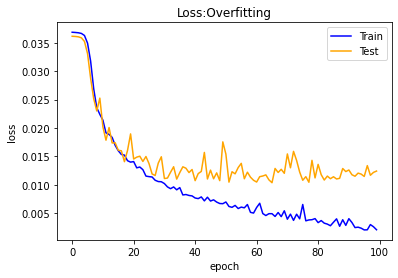

In [4]:
#plt.figure(figsize=(10,7))
plt.plot(loss_train0,label='Train',color='blue')
plt.plot(loss_test0,label='Test', color='orange')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Loss:Overfitting")
plt.legend()
plt.show()

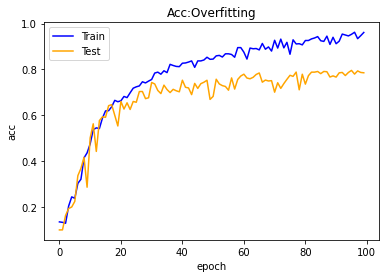

In [5]:
#plt.figure(figsize=(10,7))
plt.plot(acc_train0,label='Train',color='blue')
plt.plot(acc_test0,label='Test', color='orange')
plt.ylabel("acc")
plt.xlabel("epoch")
plt.title("Acc:Overfitting")
plt.legend()
plt.show()

In [9]:
# ========================== 丢弃率为0.2 ========================== #

dropout1 = 0.2

class Classification(torch.nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        self.hidden1 = torch.nn.Linear(num_inputs, num_hiddens) #定义隐藏层函数
        self.relu1 = torch.nn.ReLU()                       #定义隐藏层激活函数
        self.dropout_1 = torch.nn.Dropout(dropout1)
        self.hidden2 = torch.nn.Linear(num_hiddens, num_hiddens) #定义隐藏层函数
        self.relu2 = torch.nn.ReLU()                       #定义隐藏层激活函数
        self.dropout_2 = torch.nn.Dropout(dropout1)
        self.output = torch.nn.Linear(num_hiddens, num_outputs)#定义输出层函数

    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu1(x)
        x = self.dropout_1(x)
        x = self.hidden2(x)
        x = self.relu2(x)
        x = self.dropout_2(x)
        x = self.output(x)
        return x
        
net = Classification()

#初始化模型参数
init.normal_(net.hidden1.weight, mean=0, std=0.01)
init.normal_(net.hidden2.weight, mean=0, std=0.01)
init.normal_(net.output.weight, mean=0, std=0.01)
init.constant_(net.hidden1.bias, val=0)
init.constant_(net.hidden2.bias, val=0)
init.constant_(net.output.bias, val=0)

#定义优化器
optimizer = optim.SGD(net.parameters(), lr)

#训练模型
loss_train1 = []
loss_test1 = []
acc_train1 = []
acc_test1 = []
for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter:
        X = X.view((-1, num_inputs)) 
        y_hat = net(X)
        l = loss(y_hat,y).sum() 
        optimizer.zero_grad()
        l.backward()       #计算损失     
        optimizer.step()   #更新梯度
        train_l_sum += l.item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    loss_train1.append(train_l_sum/n)
    loss_test1.append(evaluate_loss(test_iter,net))
    acc_train1.append(train_acc_sum/n)
    acc_test1.append(evaluate_accuracy(test_iter,net))
    print('epoch %d, loss_train %f, loss_test %f , acc_train %f, acc_test %f '% 
          (epoch+1, loss_train1[epoch], loss_test1[epoch], acc_train1[epoch], acc_test1[epoch]))

epoch 1, loss_train 0.036836, loss_test 0.036126 , acc_train 0.110000, acc_test 0.100000 
epoch 2, loss_train 0.036794, loss_test 0.036094 , acc_train 0.163000, acc_test 0.100400 
epoch 3, loss_train 0.036737, loss_test 0.036029 , acc_train 0.175000, acc_test 0.168100 
epoch 4, loss_train 0.036625, loss_test 0.035850 , acc_train 0.190000, acc_test 0.193300 
epoch 5, loss_train 0.036266, loss_test 0.035185 , acc_train 0.220000, acc_test 0.199100 
epoch 6, loss_train 0.034978, loss_test 0.033038 , acc_train 0.225000, acc_test 0.235600 
epoch 7, loss_train 0.032007, loss_test 0.029124 , acc_train 0.303000, acc_test 0.286100 
epoch 8, loss_train 0.027330, loss_test 0.024521 , acc_train 0.370000, acc_test 0.378100 
epoch 9, loss_train 0.023824, loss_test 0.022690 , acc_train 0.383000, acc_test 0.367800 
epoch 10, loss_train 0.022374, loss_test 0.022097 , acc_train 0.423000, acc_test 0.479000 
epoch 11, loss_train 0.021230, loss_test 0.020867 , acc_train 0.453000, acc_test 0.433400 
epoch 12

epoch 92, loss_train 0.003462, loss_test 0.012462 , acc_train 0.930000, acc_test 0.763300 
epoch 93, loss_train 0.002699, loss_test 0.011309 , acc_train 0.950000, acc_test 0.794900 
epoch 94, loss_train 0.003261, loss_test 0.011335 , acc_train 0.924000, acc_test 0.791600 
epoch 95, loss_train 0.003323, loss_test 0.012288 , acc_train 0.940000, acc_test 0.779800 
epoch 96, loss_train 0.002651, loss_test 0.011723 , acc_train 0.943000, acc_test 0.788400 
epoch 97, loss_train 0.002484, loss_test 0.012435 , acc_train 0.957000, acc_test 0.774800 
epoch 98, loss_train 0.002565, loss_test 0.012190 , acc_train 0.943000, acc_test 0.787700 
epoch 99, loss_train 0.002428, loss_test 0.011347 , acc_train 0.951000, acc_test 0.793200 
epoch 100, loss_train 0.002358, loss_test 0.011956 , acc_train 0.954000, acc_test 0.779400 


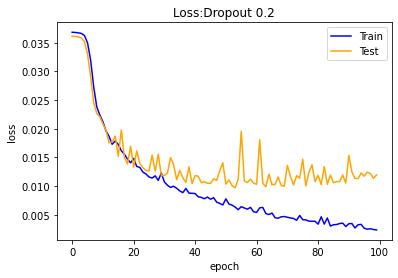

In [10]:
#plt.figure(figsize=(10,7))
plt.plot(loss_train1,label='Train',color='blue')
plt.plot(loss_test1,label='Test', color='orange')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Loss:Dropout 0.2")
plt.legend()
plt.show()

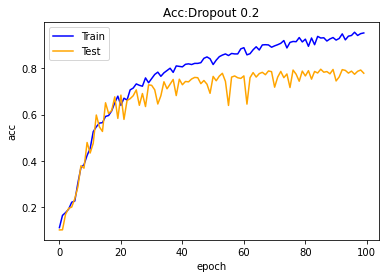

In [11]:
#plt.figure(figsize=(10,7))
plt.plot(acc_train1,label='Train',color='blue')
plt.plot(acc_test1,label='Test', color='orange')
plt.ylabel("acc")
plt.xlabel("epoch")
plt.title("Acc:Dropout 0.2")
plt.legend()
plt.show()

In [12]:
# ========================== 丢弃率为0.5 ========================== #

dropout2 = 0.5

class Classification(torch.nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        self.hidden1 = torch.nn.Linear(num_inputs, num_hiddens) #定义隐藏层函数
        self.relu1 = torch.nn.ReLU()                       #定义隐藏层激活函数
        self.dropout_1 = torch.nn.Dropout(dropout2)
        self.hidden2 = torch.nn.Linear(num_hiddens, num_hiddens) #定义隐藏层函数
        self.relu2 = torch.nn.ReLU()                       #定义隐藏层激活函数
        self.dropout_2 = torch.nn.Dropout(dropout2)
        self.output = torch.nn.Linear(num_hiddens, num_outputs)#定义输出层函数

    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu1(x)
        x = self.dropout_1(x)
        x = self.hidden2(x)
        x = self.relu2(x)
        x = self.dropout_2(x)
        x = self.output(x)
        return x
        
net = Classification()

#初始化模型参数
init.normal_(net.hidden1.weight, mean=0, std=0.01)
init.normal_(net.hidden2.weight, mean=0, std=0.01)
init.normal_(net.output.weight, mean=0, std=0.01)
init.constant_(net.hidden1.bias, val=0)
init.constant_(net.hidden2.bias, val=0)
init.constant_(net.output.bias, val=0)

#定义优化器
optimizer = optim.SGD(net.parameters(), lr)

#训练模型
loss_train2 = []
loss_test2 = []
acc_train2 = []
acc_test2 = []
for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter:
        X = X.view((-1, num_inputs)) 
        y_hat = net(X)
        l = loss(y_hat,y).sum() 
        optimizer.zero_grad()
        l.backward()       #计算损失     
        optimizer.step()   #更新梯度
        train_l_sum += l.item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    loss_train2.append(train_l_sum/n)
    loss_test2.append(evaluate_loss(test_iter,net))
    acc_train2.append(train_acc_sum/n)
    acc_test2.append(evaluate_accuracy(test_iter,net))
    print('epoch %d, loss_train %f, loss_test %f , acc_train %f, acc_test %f '% 
          (epoch+1, loss_train2[epoch], loss_test2[epoch], acc_train2[epoch], acc_test2[epoch]))

epoch 1, loss_train 0.036840, loss_test 0.036130 , acc_train 0.105000, acc_test 0.100300 
epoch 2, loss_train 0.036804, loss_test 0.036100 , acc_train 0.128000, acc_test 0.100400 
epoch 3, loss_train 0.036757, loss_test 0.036045 , acc_train 0.120000, acc_test 0.161000 
epoch 4, loss_train 0.036667, loss_test 0.035913 , acc_train 0.202000, acc_test 0.186900 
epoch 5, loss_train 0.036436, loss_test 0.035514 , acc_train 0.227000, acc_test 0.232100 
epoch 6, loss_train 0.035717, loss_test 0.034198 , acc_train 0.244000, acc_test 0.261200 
epoch 7, loss_train 0.033764, loss_test 0.031298 , acc_train 0.283000, acc_test 0.372600 
epoch 8, loss_train 0.029889, loss_test 0.026383 , acc_train 0.328000, acc_test 0.384900 
epoch 9, loss_train 0.026029, loss_test 0.023032 , acc_train 0.372000, acc_test 0.445600 
epoch 10, loss_train 0.023835, loss_test 0.021447 , acc_train 0.407000, acc_test 0.539500 
epoch 11, loss_train 0.022234, loss_test 0.021312 , acc_train 0.450000, acc_test 0.447400 
epoch 12

epoch 92, loss_train 0.004106, loss_test 0.009873 , acc_train 0.910000, acc_test 0.795800 
epoch 93, loss_train 0.004291, loss_test 0.010280 , acc_train 0.901000, acc_test 0.788600 
epoch 94, loss_train 0.004177, loss_test 0.010337 , acc_train 0.902000, acc_test 0.796500 
epoch 95, loss_train 0.004012, loss_test 0.011217 , acc_train 0.907000, acc_test 0.784900 
epoch 96, loss_train 0.003418, loss_test 0.011498 , acc_train 0.929000, acc_test 0.786400 
epoch 97, loss_train 0.003704, loss_test 0.011318 , acc_train 0.922000, acc_test 0.790900 
epoch 98, loss_train 0.003895, loss_test 0.011633 , acc_train 0.914000, acc_test 0.781900 
epoch 99, loss_train 0.003752, loss_test 0.011315 , acc_train 0.918000, acc_test 0.782400 
epoch 100, loss_train 0.003678, loss_test 0.011710 , acc_train 0.923000, acc_test 0.779400 


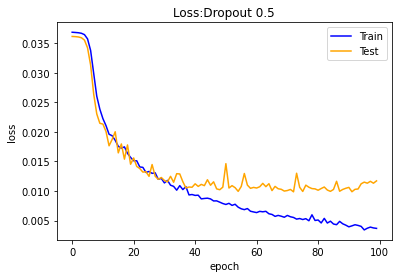

In [13]:
#plt.figure(figsize=(10,7))
plt.plot(loss_train2,label='Train',color='blue')
plt.plot(loss_test2,label='Test', color='orange')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Loss:Dropout 0.5")
plt.legend()
plt.show()

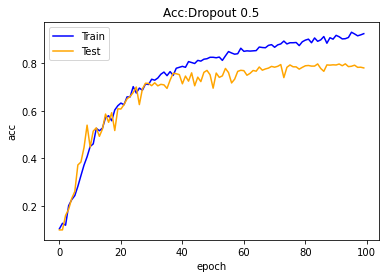

In [14]:
#plt.figure(figsize=(10,7))
plt.plot(acc_train2,label='Train',color='blue')
plt.plot(acc_test2,label='Test', color='orange')
plt.ylabel("acc")
plt.xlabel("epoch")
plt.title("Acc:Dropout 0.5")
plt.legend()
plt.show()

In [15]:
# ========================== 丢弃率为0.7 ========================== #

dropout3 = 0.7

class Classification(torch.nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        self.hidden1 = torch.nn.Linear(num_inputs, num_hiddens) #定义隐藏层函数
        self.relu1 = torch.nn.ReLU()                       #定义隐藏层激活函数
        self.dropout_1 = torch.nn.Dropout(dropout3)
        self.hidden2 = torch.nn.Linear(num_hiddens, num_hiddens) #定义隐藏层函数
        self.relu2 = torch.nn.ReLU()                       #定义隐藏层激活函数
        self.dropout_2 = torch.nn.Dropout(dropout3)
        self.output = torch.nn.Linear(num_hiddens, num_outputs)#定义输出层函数

    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu1(x)
        x = self.dropout_1(x)
        x = self.hidden2(x)
        x = self.relu2(x)
        x = self.dropout_2(x)
        x = self.output(x)
        return x
        
net = Classification()

#初始化模型参数
init.normal_(net.hidden1.weight, mean=0, std=0.01)
init.normal_(net.hidden2.weight, mean=0, std=0.01)
init.normal_(net.output.weight, mean=0, std=0.01)
init.constant_(net.hidden1.bias, val=0)
init.constant_(net.hidden2.bias, val=0)
init.constant_(net.output.bias, val=0)

#定义优化器
optimizer = optim.SGD(net.parameters(), lr)

#训练模型
loss_train3 = []
loss_test3 = []
acc_train3 = []
acc_test3 = []
for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter:
        X = X.view((-1, num_inputs)) 
        y_hat = net(X)
        l = loss(y_hat,y).sum() 
        optimizer.zero_grad()
        l.backward()       #计算损失     
        optimizer.step()   #更新梯度
        train_l_sum += l.item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    loss_train3.append(train_l_sum/n)
    loss_test3.append(evaluate_loss(test_iter,net))
    acc_train3.append(train_acc_sum/n)
    acc_test3.append(evaluate_accuracy(test_iter,net))
    print('epoch %d, loss_train %f, loss_test %f , acc_train %f, acc_test %f '% 
          (epoch+1, loss_train3[epoch], loss_test3[epoch], acc_train3[epoch], acc_test3[epoch]))

epoch 1, loss_train 0.036843, loss_test 0.036128 , acc_train 0.089000, acc_test 0.100000 
epoch 2, loss_train 0.036798, loss_test 0.036092 , acc_train 0.137000, acc_test 0.108400 
epoch 3, loss_train 0.036742, loss_test 0.036023 , acc_train 0.152000, acc_test 0.175400 
epoch 4, loss_train 0.036633, loss_test 0.035845 , acc_train 0.200000, acc_test 0.194500 
epoch 5, loss_train 0.036312, loss_test 0.035229 , acc_train 0.221000, acc_test 0.199100 
epoch 6, loss_train 0.035294, loss_test 0.033446 , acc_train 0.224000, acc_test 0.207500 
epoch 7, loss_train 0.033054, loss_test 0.030357 , acc_train 0.272000, acc_test 0.336900 
epoch 8, loss_train 0.029552, loss_test 0.026576 , acc_train 0.295000, acc_test 0.338200 
epoch 9, loss_train 0.027457, loss_test 0.024322 , acc_train 0.307000, acc_test 0.337100 
epoch 10, loss_train 0.025114, loss_test 0.023385 , acc_train 0.348000, acc_test 0.377700 
epoch 11, loss_train 0.024459, loss_test 0.021536 , acc_train 0.352000, acc_test 0.470300 
epoch 12

epoch 92, loss_train 0.006113, loss_test 0.010487 , acc_train 0.864000, acc_test 0.781800 
epoch 93, loss_train 0.006458, loss_test 0.009537 , acc_train 0.844000, acc_test 0.798500 
epoch 94, loss_train 0.005942, loss_test 0.010735 , acc_train 0.861000, acc_test 0.783700 
epoch 95, loss_train 0.006010, loss_test 0.010178 , acc_train 0.870000, acc_test 0.790600 
epoch 96, loss_train 0.006121, loss_test 0.010198 , acc_train 0.864000, acc_test 0.777100 
epoch 97, loss_train 0.006401, loss_test 0.009660 , acc_train 0.851000, acc_test 0.800800 
epoch 98, loss_train 0.005754, loss_test 0.010340 , acc_train 0.868000, acc_test 0.797400 
epoch 99, loss_train 0.006282, loss_test 0.010305 , acc_train 0.854000, acc_test 0.792100 
epoch 100, loss_train 0.005551, loss_test 0.010128 , acc_train 0.869000, acc_test 0.793500 


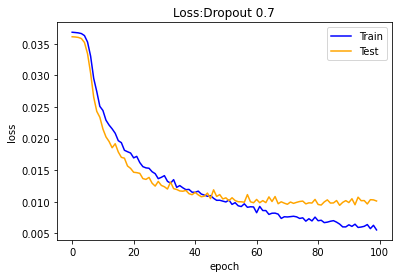

In [16]:
#plt.figure(figsize=(10,7))
plt.plot(loss_train3,label='Train',color='blue')
plt.plot(loss_test3,label='Test', color='orange')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Loss:Dropout 0.7")
plt.legend()
plt.show()

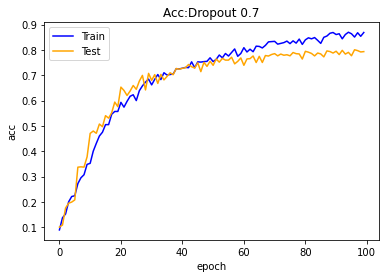

In [17]:
#plt.figure(figsize=(10,7))
plt.plot(acc_train3,label='Train',color='blue')
plt.plot(acc_test3,label='Test', color='orange')
plt.ylabel("acc")
plt.xlabel("epoch")
plt.title("Acc:Dropout 0.7")
plt.legend()
plt.show()

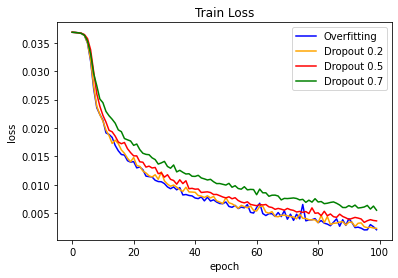

In [18]:
#plt.figure(figsize=(10,7))
plt.plot(loss_train0,label='Overfitting',color='blue')
plt.plot(loss_train1,label='Dropout 0.2', color='orange')
plt.plot(loss_train2,label='Dropout 0.5', color='red')
plt.plot(loss_train3,label='Dropout 0.7', color='green')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Train Loss")
plt.legend()
plt.show()

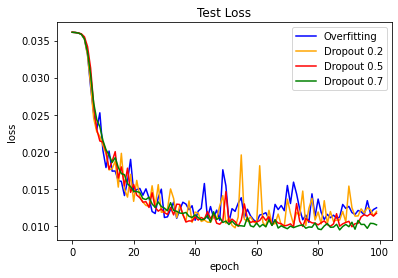

In [19]:
#plt.figure(figsize=(10,7))
plt.plot(loss_test0,label='Overfitting',color='blue')
plt.plot(loss_test1,label='Dropout 0.2', color='orange')
plt.plot(loss_test2,label='Dropout 0.5', color='red')
plt.plot(loss_test3,label='Dropout 0.7', color='green')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Test Loss")
plt.legend()
plt.show()

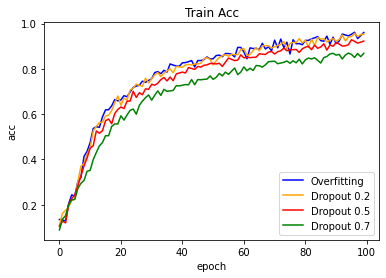

In [20]:
#plt.figure(figsize=(10,7))
plt.plot(acc_train0,label='Overfitting',color='blue')
plt.plot(acc_train1,label='Dropout 0.2', color='orange')
plt.plot(acc_train2,label='Dropout 0.5', color='red')
plt.plot(acc_train3,label='Dropout 0.7', color='green')
plt.ylabel("acc")
plt.xlabel("epoch")
plt.title("Train Acc")
plt.legend()
plt.show()

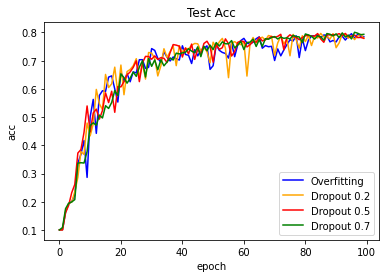

In [21]:
#plt.figure(figsize=(10,7))
plt.plot(acc_test0,label='Overfitting',color='blue')
plt.plot(acc_test1,label='Dropout 0.2', color='orange')
plt.plot(acc_test2,label='Dropout 0.5', color='red')
plt.plot(acc_test3,label='Dropout 0.7', color='green')
plt.ylabel("acc")
plt.xlabel("epoch")
plt.title("Test Acc")
plt.legend()
plt.show()